In [ ]:
import os
from glob import glob

datapath_reference = "model/datasets/modified-swiss-dwellings-v2/test"
# datapath_submission = "model/scripts/inference_msd/modified_swiss_dwellings_test_model070000"
# datapath_submission = "model/scripts/inference_msd/modified_swiss_dwellings_val_ema_0.9999_070000"
# datapath_submission = "model/scripts/inference_msd/modified_swiss_dwellings_test_model080000"
datapath_submission = "model/scripts/inference_msd/modified_swiss_dwellings_val_ema_0.9999_080000"

# datapath_submission = "model/scripts/inference_msd/modified_swiss_dwellings_val_model070000_v2"
# datapath_submission = "model/scripts/inference_msd/modified_swiss_dwellings_val_ema_0.9999_070000_v2"

# datapath_submission = "model/scripts/inference_msd/modified_swiss_dwellings_val_ema_0.9999_070000_layer_12"
# datapath_submission = "model/scripts/inference_msd/modified_swiss_dwellings_val_model070000_layer_12"

sub_name = "submission"
ref_root = os.path.join(datapath_reference, 'full_out')
sub_root = os.path.join(datapath_submission, sub_name)

ids_ref = set([int(f[:-4]) for f in os.listdir(ref_root)])
ids_sub = set([int(f[:-4]) for f in os.listdir(sub_root)])

# ids_sub_list = [int(f[:-4]) for f in os.listdir(sub_root)]
print(len(ids_ref), len(ids_sub))

791 791


In [111]:
import numpy as np
import matplotlib.pyplot as plt

from evaluation.constants import CMAP_ROOMTYPE
from evaluation.utils import colorize_floorplan

CLASSES = np.arange(0, 10)

def load_image(path, kind='ref'):
    if kind == 'sub':
        img = (plt.imread(path)*255).astype(np.uint8)
    elif kind == 'ref':
        img = np.load(os.path.join(path))[..., 0].astype(np.uint8)  # read file: *.npy
    else:
        raise NotImplementedError
    return img

ids = list(ids_sub)

In [112]:
print(list(CLASSES) + [13])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13]


## MIoU

### MIoU (per size category)

In [113]:
from tqdm.auto import tqdm
from PIL import Image

from evaluation.utils import colorize_floorplan, load_pickle
import torch

from evaluation.metrics import mean_iou

datapath_subsets = "evaluation/data"
subsets = load_pickle(os.path.join(datapath_subsets, '10-subsets-nr-areas.pickle'))
keys = list(subsets.keys())
print(keys)

key_map = {
    '20': '20',
    '25': '30',
    '30': '30',
    '35': '40',
    '40': '40',
    '45': '50',
    '50': '50',
    '55': '60',
    '60': '60',
    '1000': '60'
}

ious_rooms = {
    '20' : [],
    '30' : [],
    '40' : [],
    '50' : [],
    '60' : []
}


save_image = False
CLASSES = list(np.arange(0, 10))
CLASSES.append(13)

ids = list(ids_sub)
ious = []
image_path = 'model/scripts/inference_msd/temp_save'
for id in tqdm(ids):
    for key in keys:
        if id in subsets[key]:
            new_key = key_map[str(key)]
        else: continue
    
    # load submission and reference images
    img_sub = torch.tensor(load_image(os.path.join(sub_root, f'{id}.png'), kind='sub'))
    img_ref = torch.tensor(load_image(os.path.join(ref_root, f'{id}.npy'), kind='ref'))

    # save
    if save_image:
        img_stack = np.concatenate([colorize_floorplan(img_sub, list(np.arange(0, 13)), CMAP_ROOMTYPE),
                                    colorize_floorplan(img_ref, list(np.arange(0, 13)), CMAP_ROOMTYPE)],
                                   axis = 0).astype(np.uint8)

        img_stack = Image.fromarray(img_stack)
        img_stack.save(os.path.join(image_path, f'rooms_{new_key}_{id}.png'))

    iou = mean_iou(img_sub, img_ref, classes=CLASSES)
    
    # compute miou
    ious_rooms[new_key].append(iou)
    ious.append(iou)
    

[20, 25, 30, 35, 40, 45, 50, 55, 60, 1000]


100%|██████████| 791/791 [00:06<00:00, 116.86it/s]


In [114]:
mious_rooms = {key: {"mIoU": f"{np.mean(ious):.3f}"} for key, ious in ious_rooms.items()}
for key, item in mious_rooms.items():
    print(f"{key}: {item}")
    
# Compute overall mean IoU
overall_mean_iou = np.mean(ious)
print(f"Overall Mean IoU: {overall_mean_iou:.4f}")

20: {'mIoU': '0.134'}
30: {'mIoU': '0.127'}
40: {'mIoU': '0.128'}
50: {'mIoU': '0.126'}
60: {'mIoU': '0.123'}
Overall Mean IoU: 0.1287


### MIoU (per room class)

In [115]:
from evaluation.constants import ROOM_NAMES

iou_classes_numbers = list(filter(lambda x: x != 13, CLASSES))

ious_classes = {ROOM_NAMES[cat] : [] for cat in iou_classes_numbers}

for id in tqdm(ids):
    # load submission and reference images
    img_sub = torch.tensor(load_image(os.path.join(sub_root, f'{id}.png'), kind='sub'))
    img_ref = torch.tensor(load_image(os.path.join(ref_root, f'{id}.npy'), kind='ref'))

    # compute miou
    for cat in iou_classes_numbers:
        room_name = ROOM_NAMES[cat]
        ious_classes[room_name].append(mean_iou(img_sub, img_ref, classes=[cat]))

  0%|          | 0/791 [00:00<?, ?it/s]/home/mingyang/workspace/layout/floorplan/experiments/house-diffusion/evaluation/metrics.py:70: RuntimeWarning: Mean of empty slice
  return np.nanmean(iou_per_class)
100%|██████████| 791/791 [00:05<00:00, 132.45it/s]


In [116]:
mious_classes = {key: np.nanmean(ious) for key, ious in ious_classes.items()}
for key, item in mious_classes.items():
    print(f"{key}: {item}")

Bedroom: 0.09729504512558808
Livingroom: 0.08514311701505871
Kitchen: 0.03422380967481421
Dining: 2.769217904948577e-14
Corridor: 0.0647902479521283
Stairs: 0.04402326493345153
Storeroom: 1.1488311946232377e-13
Bathroom: 0.03177868490386321
Balcony: 0.05495878882937647
Structure: 0.09545089034616633


## Graph Compatibility

In [117]:
ref_root = os.path.join(datapath_reference, 'graph_out')
sub_root = os.path.join(datapath_submission)

# Check path existence
print(os.path.exists(ref_root))
print(os.path.exists(sub_root))
print(sub_root if os.path.exists(sub_root) else "Path does not exist")

True
True
model/scripts/inference_msd/modified_swiss_dwellings_val_model070000_layer_12


In [118]:
import torch_geometric as pyg

for file in os.listdir(sub_root):
    graph_batch = load_pickle(os.path.join(sub_root, "sample_and_gt_2.pkl"))
    break

print(graph_batch.keys())
print(graph_batch['sample'].shape, f"batchsize: {graph_batch['sample'].shape[1]}")

dict_keys(['sample', 'timesteps', 'sample_gt', 'model_kwargs', 'id'])
torch.Size([102, 4, 233, 2]) batchsize: 4


In [119]:
from evaluation.plotting.plot_from_feats import decode_from_batch

def extract_geom_from_batch(sample_and_gt, batch_size=23):
    ids = sample_and_gt["id"].tolist()
    geom_dicts = []

    for batch_index in range(batch_size):
        # Decode the predicted samples
        geom_dict = decode_from_batch(sample_and_gt["sample"], model_kwargs=sample_and_gt["model_kwargs"], batch_index=batch_index, timestep=-1)
        geom_dicts.append(geom_dict)
        geom_dict["id"] = geom_dict["id"].item()
        assert geom_dict["id"] == ids[batch_index]

    return geom_dicts

batch_size = graph_batch["sample"].shape[1]
geom_dicts = extract_geom_from_batch(graph_batch, batch_size)
print(f"the geom_dicts length: {len(geom_dicts)}")

for key, item in geom_dicts[0].items():
    print(key, f"shape: {item.shape}" if isinstance(item, (list, tuple, np.ndarray, torch.Tensor)) else "Not applicable")

the geom_dicts length: 4
corners shape: (60, 2)
room_indices shape: (60,)
room_types shape: (60,)
corner_indices shape: (60,)
connections shape: torch.Size([60, 2])
struct_corners_a shape: (2, 49)
struct_corners_b shape: (2, 49)
structure_active_mask shape: torch.Size([49])
structural_mask shape: (233, 49)
id Not applicable


In [120]:
from evaluation.plotting.plot_from_feats import prepare_for_plotting
from shapely import geometry, ops

def extract_polygons_from_geom_dict(geom_dict):
    """
    Extract polygons and process them for a given geometry dictionary.

    Args:
        geom_dict (dict): A dictionary containing geometric data.

    Returns:
        dict: A dictionary with processed polygons and additional metadata.
    """
    dwelling_id = geom_dict["id"]

    # Prepare corners and room types for plotting
    corners_dict, room_types = prepare_for_plotting(
        geom_dict["corners"], 
        geom_dict["room_indices"], 
        geom_dict["room_types"]
    )
    room_polygons = {key: geometry.Polygon(corners) for key, corners in corners_dict.items()}

    # Initialize dwelling structure
    dwelling = {
        "room_polygons": room_polygons,
        "room_types": room_types,
        "id": dwelling_id,
    }

    # Sort polygons by area (smallest to largest)
    sorted_polygons = sorted(room_polygons.items(), key=lambda p: p[1].area)
    dwelling["room_polygons"] = dict(sorted_polygons)

    # Compute non-overlapping polygons
    union_polygon = geometry.Polygon()
    non_overlapping_polygons = {}

    for room_number, polygon in sorted_polygons:
        try:
            # Subtract overlapping parts
            polygon = polygon - union_polygon
        except Exception:
            pass  # Skip if subtraction fails

        non_overlapping_polygons[room_number] = polygon

        try:
            # Update union of all polygons
            union_polygon = ops.unary_union([union_polygon, polygon])
        except Exception:
            pass  # Retain current union if operation fails

    dwelling["room_polygons_non_overlapping"] = non_overlapping_polygons

    return dwelling

In [121]:
dwellings = []

for geom_dict in geom_dicts:
    dwellings.append(extract_polygons_from_geom_dict(geom_dict))

TopologyException: Input geom 0 is invalid: Self-intersection at 278.03837471783294 383.35891647855533
TopologyException: side location conflict at 278.03837471783294 383.35891647855533. This can occur if the input geometry is invalid.
TopologyException: Input geom 0 is invalid: Self-intersection at 302 468.11111111111109
TopologyException: side location conflict at 302 468.11111111111109. This can occur if the input geometry is invalid.
TopologyException: Input geom 0 is invalid: Self-intersection at 302.03893805309735 389.45309734513273
TopologyException: side location conflict at 302.03893805309735 389.45309734513273. This can occur if the input geometry is invalid.
TopologyException: Input geom 0 is invalid: Self-intersection at 234.91666666666666 357.58333333333331
TopologyException: side location conflict at 234.91666666666666 357.58333333333331. This can occur if the input geometry is invalid.
TopologyException: Input geom 0 is invalid: Self-intersection at 235.12775330396477 20

In [122]:
import networkx as nx
import numpy as np
from shapely.geometry import Polygon

def polygon_to_list(polygon: Polygon) -> list:
    return list(zip(*polygon.exterior.coords.xy))

def polygon_to_array(polygon: Polygon) -> np.array:
    return np.array(polygon_to_list(polygon))

def swap_xy_coords(coords):
    for x, y in coords:
        yield (y, x)

def swap_xy_polygon(geom: Polygon) -> Polygon:
    ring = geom.exterior
    shell = type(ring)(list(swap_xy_coords(ring.coords)))
    holes = list(geom.interiors)
    for pos, ring in enumerate(holes):
        holes[pos] = type(ring)(list(swap_xy_coords(ring.coords)))
    return type(geom)(shell, holes)

def extract_graph(dwelling, buffer_amount=4):
    """Extract room access graph from dwelling
    dwelling: the dictionary that has room_types and room_polygons_non_overlapping dicts.
    buffer_amount: the amount each room is buffered by before checking overlap"""

    room_types = dwelling["room_types"]

    room_polygons = dwelling["room_polygons_non_overlapping"]

    graph = nx.Graph()

    graph.add_nodes_from(room_polygons)

    for room_number, polygon in room_polygons.items():

        room_type = room_types[room_number]

        graph.nodes[room_number]["room_type"] = room_type

        # centroid and swap x and y
        graph.nodes[room_number]["centroid"] = np.array(polygon.centroid.coords)[0][::-1]

        while not isinstance(polygon, geometry.Polygon):
            polygon = max(polygon.geoms, key=lambda p: p.area)

        if isinstance(polygon, geometry.MultiPolygon):
            polygon_swapped = swap_xy_polygon(max(polygon.geoms, key=lambda p: p.area))
            graph.nodes[room_number]["geometry"] = polygon_to_list(polygon_swapped)
        else:
            polygon_swapped = swap_xy_polygon(polygon)
            graph.nodes[room_number]["geometry"] = polygon_to_list(polygon_swapped)

        for other_number, other_polygon in room_polygons.items():
            if room_number == other_number:
                continue

            if polygon.buffer(buffer_amount).intersects(other_polygon.buffer(buffer_amount)):
                graph.add_edge(room_number, other_number, adjacent=True)

    graph_sorted = nx.Graph()
    graph_sorted.add_nodes_from(sorted(graph.nodes(data=True)))
    graph_sorted.add_edges_from(sorted(graph.edges(data=True)))

    return graph_sorted

# Buffer amount determines by how many pixels room polygons are enlarged
graph = extract_graph(dwellings[0], buffer_amount=4)

In [123]:
print(graph)

Graph with 15 nodes and 20 edges


In [124]:
def plot_graph(G, ax, c_node='black', c_edge=['white']*4, dw_edge=False, pos=None, node_size=10,
               edge_size=10, labels=True, label_size=20):

    """
    Plots the adjacency or access graph of a floor plan's corresponding graph structure.
    """

    # position
    if pos is None:
        pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=c_node, ax=ax)
    if labels:
        labels = labels if isinstance(labels, dict) else None
        nx.draw_networkx_labels(G, pos, labels=labels, font_color='white', font_size=label_size, ax=ax)

    # edges
    if dw_edge:
        epass = [(u, v) for (u, v, d) in G.edges(data=True) if d["connectivity"] == 'passage']
        edoor = [(u, v) for (u, v, d) in G.edges(data=True) if d["connectivity"] == 'door']
        efront = [(u, v) for (u, v, d) in G.edges(data=True) if d["connectivity"] == 'entrance']
        # red full for passage, red dashed for door, yellow dashed for front
        nx.draw_networkx_edges(G, pos, edgelist=epass, edge_color=c_edge[1],
                               width=edge_size, ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=edoor, edge_color=c_edge[2],
                               width=edge_size, style="dashed", ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=efront, edge_color=c_edge[3],
                               width=edge_size, style="-.", ax=ax)
    else:
        nx.draw_networkx_edges(G, pos, edge_color=c_edge[0],
                               width=edge_size, ax=ax)

    ax.axis('off')

In [125]:
# from evaluation.plot import set_figure, plot_polygon
# from evaluation.constants import CMAP_ROOMTYPE, COLORS_ROOMTYPE

# fs = 10
# fig, axs = set_figure(nc=batch_size,nr=2, fs=10) #, fs_title=5)

# for i, ax in enumerate(axs):
#     j = int(np.floor(i / 2))

#     dwelling = dwellings[j]
#     id = dwelling['id']

#     # load predicted and ground truth graphs
#     graph_extract_buffer_amount = 5
#     graph_pred = extract_graph(dwelling, buffer_amount=graph_extract_buffer_amount)
#     graph_out = load_pickle(os.path.join(datapath_reference, 'graph_out', f'{id}.pickle'))

#     # compute score
#     count = 0
#     edge_colors = []
#     for edge in graph_pred.edges:

#         if edge in graph_out.edges:
#             edge_colors.append('black')
#             count += 1
#         else:
#             edge_colors.append('red')

#     graph_similarity = count / len(graph_out.edges)

#     # plot PREDICTED
#     if i % 2 == 0:
#         # room geometries are in the "geometry" attribute
#         rooms = [Polygon(n) for _, n in graph_pred.nodes('geometry')]
#         # loop over room and color combination and plot
#         colors = [np.array(CMAP_ROOMTYPE(n)).reshape(1,4) for _, n in graph_pred.nodes('room_type')]
#         [plot_polygon(ax, room, fc=color, ec=color) for room, color in zip(rooms, colors)]

#         # plot graph
#         # coloring is based on our own colormap "CMAP_ROOMTYPE"
#         # positioning of the nodes are in the "centroid" attribute
#         pos = {n: np.array(graph_pred.nodes[n]['centroid']) for n in graph_pred.nodes}

#         plot_graph(graph_pred, ax, c_node='black', dw_edge=False, c_edge=[edge_colors]*4, pos=pos, node_size=fs*50, edge_size=fs/3, labels=True, label_size=20)

#         _ = ax.set_aspect('equal')
#         ax.set_title(f'ID={id}\n'
#                   f'g-sim={graph_similarity:4f}')

#     elif i % 2 == 1:

#         # plot full layout (similar to image)
#         # room geometries are in the "geometry" attribute
#         rooms = [Polygon(n) for _, n in graph_out.nodes('geometry')]
#         # loop over room and color combination and plot
#         colors = [np.array(CMAP_ROOMTYPE(n)).reshape(1,4) for _, n in graph_out.nodes('room_type')]
#         [plot_polygon(ax, room, fc=color, ec=color) for room, color in zip(rooms, colors)]

#         # plot graph
#         # coloring is based on our own colormap "CMAP_ROOMTYPE"
#         # positioning of the nodes are in the "centroid" attribute
#         pos = {n: np.array(graph_out.nodes[n]['centroid']) for n in graph_out.nodes}
#         labels = {n:n for n in graph_out.nodes}
#         plot_graph(graph_out, ax, c_node='black', dw_edge=False, c_edge=['black']*4, pos=pos, node_size=fs*50, edge_size=fs/3, labels=True)

#         _ = ax.set_aspect('equal')

#         ax.set_title(f'ID={id}\n'
#                   f'g-sim={graph_similarity:4f}')

### From here to calculate graph compatibility

In [126]:
dwellings = []

print(f"Processing directory: {sub_root}")
for file in tqdm(os.listdir(sub_root), desc="Processing files"):
    if not file.endswith(".pkl"):
        continue
    
    try:
        graph_batch = load_pickle(os.path.join(sub_root, file))
        batch_size = graph_batch["sample"].shape[1]
        geom_dicts = extract_geom_from_batch(graph_batch, batch_size=batch_size)
        
        for geom_dict in geom_dicts:
            id = geom_dict['id']
            if id in ids:
                # print(id)
                dwelling = extract_polygons_from_geom_dict(geom_dict)
                dwellings.append(dwelling)
    except Exception as e:
        raise e


Processing directory: model/scripts/inference_msd/modified_swiss_dwellings_val_model070000_layer_12


Processing files:   0%|          | 0/201 [00:00<?, ?it/s]TopologyException: Input geom 0 is invalid: Self-intersection at 413.07782101167317 132.42801556420233
TopologyException: side location conflict at 413.07782101167317 132.42801556420233. This can occur if the input geometry is invalid.
TopologyException: Input geom 0 is invalid: Self-intersection at 473.3580753450205 181.87952256620665
TopologyException: side location conflict at 210.43502824858757 215.74350282485875. This can occur if the input geometry is invalid.
TopologyException: side location conflict at 210.43502824858757 215.74350282485875. This can occur if the input geometry is invalid.
TopologyException: Input geom 0 is invalid: Self-intersection at 174.7123287671233 118.68493150684931
TopologyException: side location conflict at 174.7123287671233 118.68493150684931. This can occur if the input geometry is invalid.
TopologyException: Input geom 1 is invalid: Self-intersection at 210.43502824858757 215.74350282485875
To

In [127]:
graph_extract_buffer_amount = 5
graph_distances = {}

for dwelling in tqdm(dwellings, desc="Processing dwellings"):
    id = dwelling['id']

    try:
        graph = extract_graph(dwelling, buffer_amount=graph_extract_buffer_amount)
    except Exception:
        continue

    graph_out_path = os.path.join(datapath_reference, 'graph_out', f'{id}.pickle')
    graph_out = load_pickle(graph_out_path)

    count = 0
    edge_colors = []
    for edge in graph_out.edges:
        if edge in graph.edges:
            count += 1
        else:
            edge_colors.append('red')

    graph_distances[id] = count / len(graph_out.edges)

Processing dwellings: 100%|██████████| 791/791 [00:49<00:00, 16.04it/s]


In [128]:
np.mean(list(graph_distances.values())), np.nanmean(list(graph_distances.values()))

(0.2703637779052995, 0.2703637779052995)

Mean Graph Similarity:	0.270


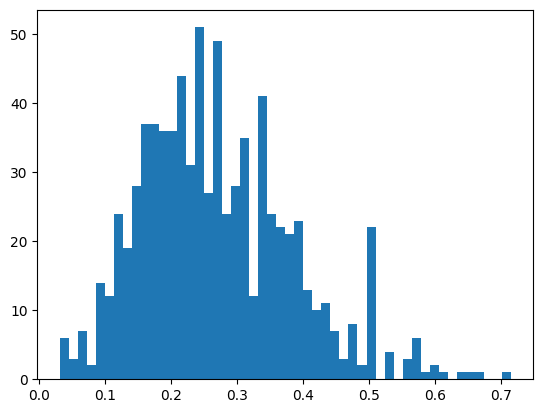

In [129]:
mean_graph_similarity = np.nanmean(list(graph_distances.values()))
print(f'Mean Graph Similarity:\t{mean_graph_similarity:.3f}')

_, ax = plt.subplots(1, 1)
_ = ax.hist(graph_distances.values(), bins=50)

### Mean Graph Similarity (per size category)

In [130]:
subsets = load_pickle(os.path.join(datapath_subsets, '10-subsets-nr-areas.pickle'))
keys = list(subsets.keys())
print(keys)

key_map = {
    '20': '20',
    '25': '30',
    '30': '30',
    '35': '40',
    '40': '40',
    '45': '50',
    '50': '50',
    '55': '60',
    '60': '60',
    '1000': '60'
}

graph_distances_rooms = {
    '20' : [],
    '30' : [],
    '40' : [],
    '50' : [],
    '60' : []
}

for dwelling in tqdm(dwellings):
    id = dwelling['id']
    if id not in graph_distances:
        print(f"skipping {id=}")
        continue
    for key in keys:
        if id in subsets[key]:
            new_key = key_map[str(key)]
        else: continue

    # compute miou
    graph_distances_rooms[new_key].append(graph_distances[id])

[20, 25, 30, 35, 40, 45, 50, 55, 60, 1000]


100%|██████████| 791/791 [00:00<00:00, 41103.82it/s]

skipping id=15056


In [131]:
import pandas as pd
mean_graph_distances_rooms = {key: {"compatibility": f"{np.mean(dist):.3f}"} for key, dist in graph_distances_rooms.items()}
# print(mean_graph_distances_rooms)
# pd.DataFrame(mean_graph_distances_rooms).to_csv()

for key, item in mean_graph_distances_rooms.items():
    print(f"{key}: {item}")

mean_graph_similarity = np.nanmean(list(graph_distances.values()))
print(f'Mean Graph Similarity:\t{mean_graph_similarity:.3f}')

20: {'compatibility': '0.329'}
30: {'compatibility': '0.273'}
40: {'compatibility': '0.226'}
50: {'compatibility': '0.226'}
60: {'compatibility': '0.189'}
Mean Graph Similarity:	0.270
